# Scikit-learn Interface Tutorial

This tutorial will walk you through using the sklearn style DAGRegressor and DAGClassifier models on two familiar datasets: Diabetes and Breast Cancer.


## How it fits into the bigger causalnex picture
The sklearn wrappers are an alternative to the structure learning step.
The fitted model objects include a `model.graph_` attribute that can be used for visualisation, post-processing, and most importantly the probability fitting step of the BayesianNetwork, the second stage of the causalnex workflow.

## DAGRegressor
This section demonstrates the performance of the DAGRegressor on a real-world dataset. The main things to note in this section are:

- The scale sensitivity of the algorithm

- Interpretability of nonlinear `.coef_`

### The Diabetes dataset

The diabetes dataset presents a standard benchmark regression exercise. The objective is to predict disease progression, given a set of features.

**Note**: a previous version of this tutorial used the Boston housing data for its demonstration. For more information about the racial discrimination present in the Boston housing data, see the [github issue](https://github.com/quantumblacklabs/causalnex/issues/91) that triggered the removal. To learn more about this dataset, we suggest checking out a [sklearn issue](https://github.com/scikit-learn/scikit-learn/issues/16155) that has resulted in its deprecation.

The meaning of available features for the diabetes dataset is shown below.


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join("../../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
from IPython.display import display, Markdown
import pandas as pd

def variable_score_card(protected_variable: pd.Series, target: pd.Series, n_bins: int = 3):
    
    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    def pct_size():
        def pct_size_(x):
            return np.round(x.size / len(target) * 100, 1)
        pct_size_.__name__ = 'pct_size'
        return pct_size_
    
    display(Markdown("**Score card for ``%s``**" % protected_variable.name))
    
    agg_funcs = ["size", pct_size(), "mean", "std", "min", percentile(10), "median", percentile(90), "max"]
    if protected_variable.dtype != 'O' and protected_variable.nunique() < 10:
        return y.groupby(protected_variable).agg(agg_funcs).reset_index()
    else:
        bin_array = pd.cut(protected_variable, bins=n_bins)
        return y.groupby(bin_array).agg(agg_funcs).reset_index()

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
data = load_diabetes()
print(data["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

### Dataset bias evaluation

As we're dealing with the data of the individuals and the predictions of the model may have a profound impact on their lives, we should evaluate the dataset on the potential presence of bias.

1. **Sample bias/Data collection**: 
  * The papers do not explain the protocol of how the samples were generated, therefore unintended biases that could have been introduced can not be detected.
  * Data biases could be a result of inequalities in access to healthcare, e.g. due to insurance coverage, limited access to diabetes screenings in underdeveloped regions or neighbourhoods. Undocumented sensitive variables, e.g. ethnicity, would need to be statistically independent of the choice to be included in the dataset. 
2. **Data bias estimation with respect to available sensitive attributes**: The dataset includes direct information on `age` and `sex`, note that both are standardized. A careful evaluation of the possible bias in the sensitive attributes, includes the comparison of ratios in groups in the data with their population rates, or benchmarks from literature. In our case, without information about geography nor ethnicity and the masking of the actual values the variables take, there is hardly any conclusion to be made from the bias estimation. The breakdown below shows roughly uniform distribution across the two variables. Follow up questions to be assessed include: Which one of the variables is each sex? can we expect the disease to progress similarly in both sexes? and similarly for age distribution. 
3. **Risks for model deployment**: We cannot determine the distribution across some omitted sensitive variables, nor have the information regarding the data gathering. This poses *fairness risks when deploying a model trained on the dataset on populations different to the study cohort*.

*When deploying the model in the context of healthcare, make sure it is equally performant in the subgroups with respect to sensitive attributes and their intersection.*

*We recommend always assessing the bias and fairness risks at each step of the process (from problem understanding, data collection, processing, modelling and deployment), when working on models to be deployed, to minimize undesired outcomes*


In [4]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")

variable_score_card(protected_variable=X["sex"], target=y)

**Score card for ``sex``**

,sex,size,pct_size,mean,std,min,percentile_10,median,percentile_90,max
0,-0.044642,235,53.2,149.021277,75.905781,25.0,59.4,140.0,266.8,346.0
1,0.050680,207,46.8,155.666667,78.453313,39.0,62.2,141.0,264.4,341.0


In [5]:
variable_score_card(protected_variable=X["age"], target=y)

**Score card for ``age``**

,age,size,pct_size,mean,std,min,percentile_10,median,percentile_90,max
0,"(-0.107, -0.0346]",117,26.5,134.273504,69.369777,39.0,57.6,118.0,225.8,346.0
1,"(-0.0346, 0.0381]",212,48.0,153.278302,82.337721,25.0,53.0,140.5,272.0,341.0
2,"(0.0381, 0.111]",113,25.6,168.477876,70.996617,39.0,78.4,163.0,272.8,332.0


Lets initially benchmark the performance of an `ElasticNetCV` fitted across the entire dataset.

In [6]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from sklearn.linear_model import ElasticNetCV
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.475


### Linear DAGRegressor

The DAGRegressor has several parameters which can be used to better fit a more complicated noisy DAG:

- `alpha`: The l1 (lasso) regularisation parameter. Increasing this creates a sparser DAG.

- `beta`: The l2 (ridge) regularisation parameter.

It was decided to use `alpha` and `beta` rather than `alpha` and `l1_ratio` like in sklearn elasticnet to uncouple the parameters during optimisation.

There are several parameters which are also of interest which have good defaults, but we highlight here:

- `dependent_target`: This forces the target variable y to be only a child node. This is important for performance because in some cases `X -> y` is indistinguishable from `y -> X`. Enabling this (default enabled) ensures that the regressor performance at least matches linear regression. The trade-off is that the learned structure might be less accurate if y does cause other features.

- `enforce_dag`: This thresholds the learned structure model until the system is a DAG. This is useful for removing the small straggler connections which enables the DAG to be visualised easier. It does not impact performance, because the regressor still uses those connections under the hood.

MEAN R2: 0.478
age    0.000000
sex    0.000000
bmi    0.304172
bp     0.000000
s1     0.000000
s2     0.000000
s3     0.000000
s4     0.000000
s5     0.277010
s6     0.000000
dtype: float64


(<Figure size 821.52x491.04 with 1 Axes>, <AxesSubplot:>)

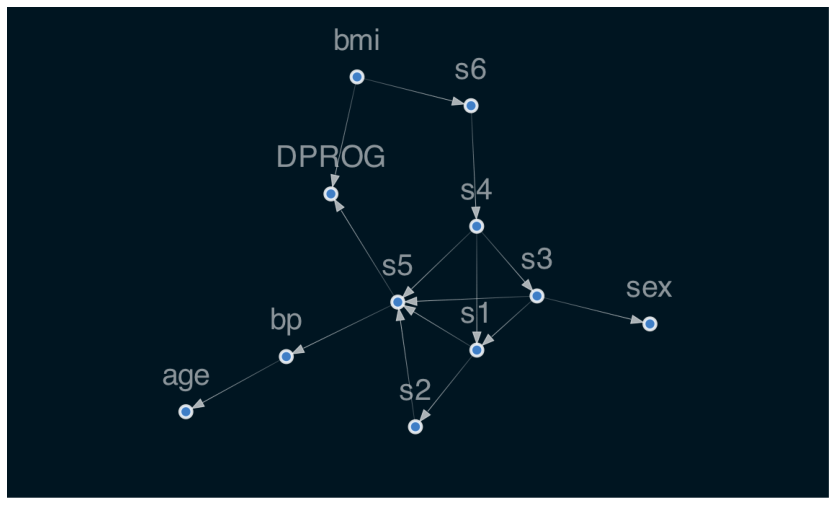

In [7]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=None,
    dependent_target=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print(pd.Series(reg.coef_, index=names))
reg.plot_dag(enforce_dag=True)

### Nonlinear DAGRegressor

Specifying a nonlinear model is extremely simple, only a single parameter needs to be altered: `hidden_layer_units`

`hidden_layer_units` takes _any_ **iterable** of **integers**:

- The value specifies the number of perceptrons to use in each nonlinear MLP layer:

- The number of elements in the iterable determines the number of hidden layers.

The more layers and more perceptrons per layer, the more complicated the function which can be fit. The trade off is a greater tendency to overfit, and slower fitting.

A good default starting argument is ~\[5]. This is unlikely to overfit, and usually demonstrates immediately whether the DAG has nonlinear components.

The setting of the `alpha` and `beta` parameters is very important.
Typically `beta` is more important than `alpha` when using nonlinear layers. This is because l2 is applied across all layers, whereas l1 is only applied to the first layer.
A good starting point is `~beta=0.5`.

**NOTE**: It is very important to scale your data!

The nonlinear layers contain sigmoid nonlinearities which can become saturated with unscaled data. Also, unscaled data means that regularisation parameters do not impact weights across features equally.

For convenience, setting `standardize=True` scales both the X and y data during fit. It also inverse transforms the y on predict similar to the sklearn `TransformedTargetRegressor`.

MEAN R2: 0.477


(<Figure size 585.36x369.36 with 1 Axes>, <AxesSubplot:>)

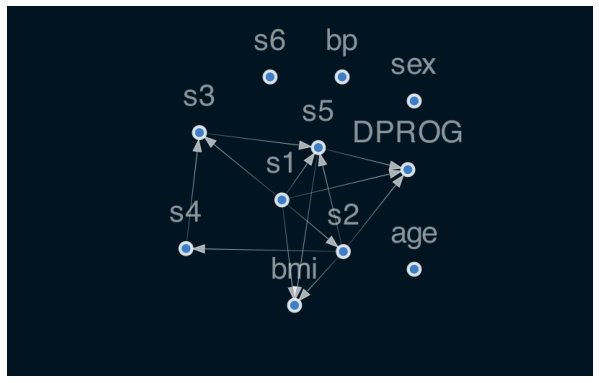

In [8]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[2],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

#### Dependent Target

In supervised learning, one would want to have `dependent_target=True` (the default value). However, setting the `dependent_target=False` can give better insight into the overall nonlinear structure of the data, but it also has an impact on performance as shown below

This is effectively the same as fitting causalnex on the data using from_pandas, but using the sklearn interface provides a set of useful convenience functions not present in the base causalnex implementation.

MEAN R2: 0.380


(<Figure size 609.84x447.84 with 1 Axes>, <AxesSubplot:>)

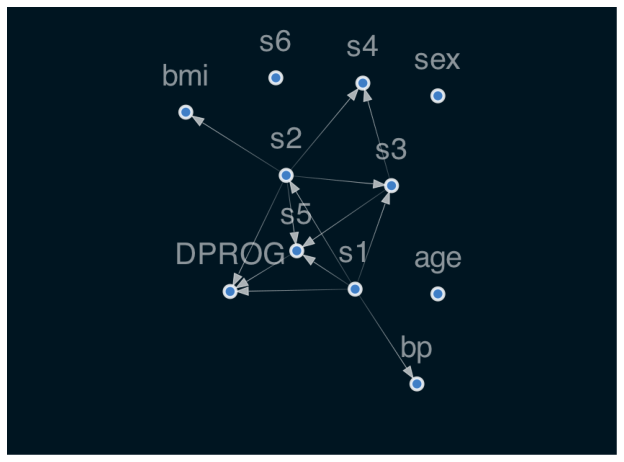

In [9]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(42)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[2],
    dependent_target=False,
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
reg.plot_dag(enforce_dag=True)

#### Interpreting the nonlinear DAG

For nonlinear analysis, understanding the impact of one feature on another is not as simple as taking the mean effect as in the linear case.
Instead, a combination of `reg.coef_` and `reg.feature_importances` should be used:

- `reg.coef_` provides the mean **directional** effect of all the features on the target. This gives average directional information, but can be misleading in terms of magnitude if the feature has a positive _and_ negative effect on the target.

- `reg.feature_importances_` provides the mean **magnitude** effect of the features on the target. These values will be _strictly larger_ than the `reg.coef_` because there are no cancellation effects due to sign differences. 

The magnitude difference between the `reg.coef_` and `reg.feature_importances_` values can give insight into the _degree of directional variability_ of the parameter:

- A large difference means that the parameter has **large positive and negative effects** on the target.

- A zero difference means that the parameter always has the same directional impact on the target.

MEAN R2: 0.438
MEAN EFFECT DIRECTIONAL:
age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1    -0.474895
s2     0.331620
s3     0.000000
s4     0.000000
s5     0.432986
s6     0.000000
dtype: float64
MEAN EFFECT MAGNITUDE:
age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1     0.474895
s2     0.332475
s3     0.000000
s4     0.000000
s5     0.433416
s6     0.000000
dtype: float64


(<Figure size 600.48x500.4 with 1 Axes>, <AxesSubplot:>)

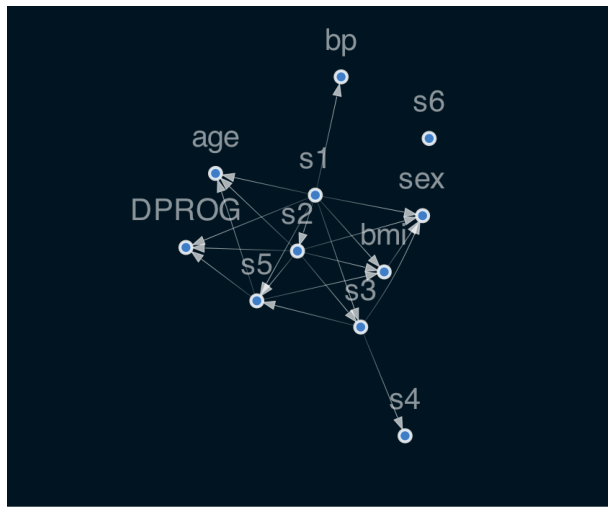

In [10]:
from sklearn.datasets import load_diabetes
import torch
torch.manual_seed(0)
data = load_diabetes()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGRegressor
reg = DAGRegressor(
    threshold=0.0,
    alpha=0.0001,
    beta=0.2,
    hidden_layer_units=[5],
    standardize=True,
    enforce_dag=True,
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="DPROG")
reg.fit(X, y)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=names))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=names))
reg.plot_dag(enforce_dag=True)

The `reg.get_edges_to_node` method allows for analysis of other edges in the graph easily.

Passing in `data="weight"` returns the mean effect magnitude of the variables on the requested node. It is equivalent to the `reg.feature_importances` return for the target node.

Passing in `data="mean_effect"` returns the mean directional effect.

Below we show the effect of the variables on `s3` as mean magnitude/absolute effect and mean directional effect. 

In [11]:
vals = reg.get_edges_to_node("s3", data="weight").copy()
vals[vals.abs() < 0.01] = 0
vals

age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1     1.518069
s2     1.408495
s3     0.000000
s4     0.000000
s5     0.000000
s6     0.000000
dtype: float64

In [12]:
vals = reg.get_edges_to_node("s3", data="mean_effect")
vals[vals.abs() < 0.01] = 0
vals

age    0.000000
sex    0.000000
bmi    0.000000
bp     0.000000
s1     1.518069
s2    -1.408495
s3     0.000000
s4     0.000000
s5     0.000000
s6     0.000000
dtype: float64

___
## DAGClassifier
This section demonstrates the performance of the algorithm on a real-world dataset.

The interface is very similar to the DAGRegressor so key details should be found there.

### Binary Classifier
#### The Breast Cancer dataset

In [13]:
from sklearn.datasets import load_breast_cancer
print(load_breast_cancer(return_X_y=False)["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

#### Dataset bias evaluation

1. **Sample bias/Data collection**: 
  * The papers do not explain the protocol of how the samples were generated.
  * Undocumented sensitive variables, e.g. ethnicity or age, would need to be statistically independent of the choice to be included in the dataset. Violations could include inequalities in access to healthcare, e.g. due to insurance coverage, limited access too diabetes screenings in underdeveloped regions or neighbourhoods.
2. **Data bias estimation with respect to available sensitive attributes**: All variables are from a cell nuclei level, there are no directly sensitive variables included. This poses *fairness risks when interpreting the model results and moving forward with conclusions/generalizations from the study*.
3. **Risks for model deployment**: We cannot determine the distribution across some omitted sensitive variables, nor we have the information regarding the data gathering. This poses *fairness risks when deploying a model trained on the dataset on populations different to the study cohort*.
*We recommend always assessing the bias and fairness risks at each step of the process (from problem understanding, data collection, processing, modelling and deployment), when working on models to be deployed, to minimize undesired outcomes*

In [14]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="NOT CANCER")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))

MEAN Score: 0.944
MEAN EFFECT DIRECTIONAL CLASS 0:
worst radius               1.041636
mean radius                0.979513
mean texture               0.469473
texture error              0.390102
mean perimeter             0.260891
perimeter error            0.156270
radius error               0.042703
smoothness error          -0.003320
fractal dimension error   -0.003441
mean fractal dimension    -0.010169
symmetry error            -0.012280
concave points error      -0.013242
worst area                -0.014235
mean area                 -0.016286
mean smoothness           -0.036755
compactness error         -0.037005
mean symmetry             -0.050893
concavity error           -0.051575
worst fractal dimension   -0.051730
worst smoothness          -0.066606
mean concave points       -0.101790
area error                -0.111632
worst symmetry            -0.161130
mean compactness          -0.172538
worst concave points      -0.195730
worst perimeter           -0.238059
mean concavit

MEAN Score: 0.975
MEAN EFFECT DIRECTIONAL CLASS 0:
fractal dimension error    0.435006
texture error              0.253090
mean compactness           0.225626
symmetry error             0.112259
compactness error          0.094851
worst compactness          0.087924
mean fractal dimension     0.034403
concavity error            0.030805
mean texture               0.024233
mean symmetry             -0.000012
mean perimeter            -0.000603
mean area                 -0.003670
mean radius               -0.005750
mean smoothness           -0.007812
perimeter error           -0.021268
concave points error      -0.088604
smoothness error          -0.173150
worst smoothness          -0.174532
worst fractal dimension   -0.193018
worst perimeter           -0.241930
worst concavity           -0.251617
worst symmetry            -0.253782
worst concave points      -0.255410
mean concavity            -0.317477
mean concave points       -0.322275
worst area                -0.427581
worst radius 

(<Figure size 920.88x581.04 with 1 Axes>, <AxesSubplot:>)

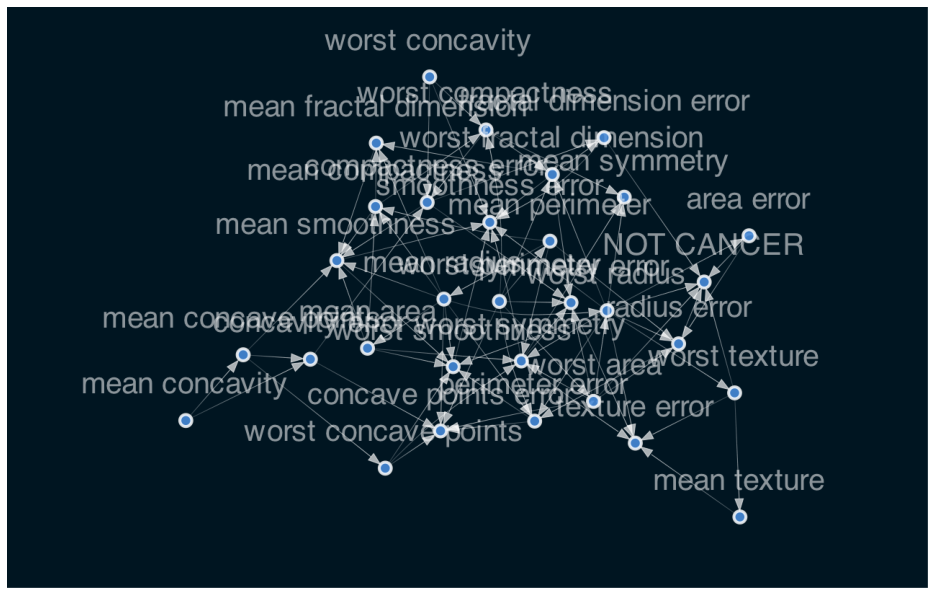

In [15]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="NOT CANCER")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)

### Categorical Classifier
#### The Iris dataset

In [16]:
from sklearn.datasets import load_iris
print(load_iris(return_X_y=False)["DESCR"])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### Dataset bias evaluation
The dataset does not include personal information and is unlikely to include socially biased data.

MEAN Score: 0.967
MEAN EFFECT DIRECTIONAL CLASS 0:
sepal width (cm)     0.218027
sepal length (cm)   -0.173042
petal width (cm)    -0.314497
petal length (cm)   -0.358783
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 1:
petal length (cm)    0.247208
petal width (cm)     0.195806
sepal length (cm)    0.153111
sepal width (cm)    -0.150111
dtype: float64
MEAN EFFECT DIRECTIONAL CLASS 2:
petal width (cm)     1.794545
petal length (cm)    1.683933
sepal length (cm)   -0.104375
sepal width (cm)    -0.345436
dtype: float64


(<Figure size 549.36x348.48 with 1 Axes>, <AxesSubplot:>)

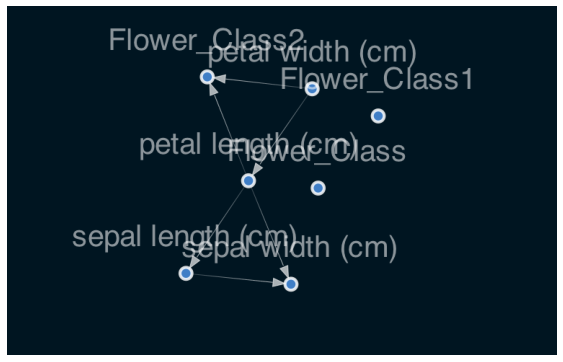

In [17]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data, data.target
names = data["feature_names"]

from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=names)
y = pd.Series(y, name="Flower_Class")
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=names).sort_values(ascending=False))
clf.plot_dag(True)